In [1]:
!pip install torch torchvision transformers diffusers peft accelerate pillow lpips safetensors

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-10.3.9

# Import thư viện

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image, ImageEnhance, ImageFilter
import pandas as pd
from torchvision import transforms
from transformers import CLIPTokenizer, CLIPTextModel
from diffusers import (
    StableDiffusionPipeline, 
    DDIMScheduler, 
    DPMSolverMultistepScheduler,
    UNet2DConditionModel,
    AutoencoderKL
)
from peft import LoraConfig, get_peft_model
import os
import numpy as np
import random
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, ReduceLROnPlateau
from IPython.display import Image as IPImage, display
from tqdm import tqdm
import time
import warnings
from torch.amp import autocast, GradScaler
from safetensors.torch import save_file, load_file
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from collections import defaultdict
import json
import gc
from torchvision.utils import make_grid
import torchvision.transforms.functional as TF
from peft import PeftModel

warnings.filterwarnings("ignore", category=UserWarning, module="torch")


2025-05-26 09:58:23.534302: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748253503.757955      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748253503.821411      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# =============================================================================
# CONFIGURATION & SETUP
# =============================================================================

class Config:
    """Centralized configuration for better parameter management"""
    # Paths
    input_dir = "/kaggle/input/fashion-data/fashion_images"
    # input_dir = "/kaggle/input/fahsion-100/fashion_images_100"
    output_dir = "/kaggle/working/fashion_images_resized"
    latent_dir = "/kaggle/working/fashion_latents"
    model_save_dir = "/kaggle/working/fashion_diffusion_best"
    logs_dir = "/kaggle/working/logs"
    
    # Training hyperparameters (IMPROVED - based on analysis)
    batch_size = 8  # Increased for stability
    learning_rate = 2.5e-6  # Reduced for stability
    num_steps = 2000  # Increased for better convergence
    warmup_steps = 500  # Better warmup 
    weight_decay = 0.005  # Reduced weight decay 
    gradient_clip_norm = 0.3  # Tighter clipping 
    
    # LoRA configuration (IMPROVED - reduced overfitting risk)
    lora_rank = 12  # Reduced to prevent overfitting 
    lora_alpha = 24  # Adjusted proportionally with rank
    lora_dropout = 0.1  # Kept same for feature retention
    
    # Validation & Early stopping (IMPROVED - more frequent monitoring)
    val_check_interval = 500  # More frequent validation (was 500)
    patience = 10  # More patience for early stopping (was 5)
    min_delta = 0.001
    
    # Image processing
    image_size = 512
    latent_size = 64
    
    # Generation parameters
    guidance_scale = 12.0  # Higher guidance for better prompt adherence
    num_inference_steps = 50  # More steps for better quality
    
    # Seeds for reproducibility
    seed = 42

def set_seed(seed):
    """Set seeds for reproducible training"""
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(Config.seed)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create directories
for dir_path in [Config.output_dir, Config.latent_dir, Config.model_save_dir, Config.logs_dir]:
    os.makedirs(dir_path, exist_ok=True)

def check_system_requirements():
    """Check system requirements and dependencies before training"""
    print("🔍 Checking system requirements...")
    
    issues = []
    warnings = []
    
    # Check CUDA availability
    if not torch.cuda.is_available():
        issues.append("CUDA not available - training will be very slow on CPU")
    else:
        gpu_count = torch.cuda.device_count()
        gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
        print(f"✅ CUDA available: {gpu_count} GPU(s), {gpu_memory:.2f} GB memory")
        
        if gpu_memory < 8:
            warnings.append(f"Low GPU memory ({gpu_memory:.2f} GB) - consider reducing batch size")
    
    # Check required directories
    required_dirs = [Config.input_dir]
    for dir_path in required_dirs:
        if not os.path.exists(dir_path):
            issues.append(f"Required directory not found: {dir_path}")
    
    # Check if output directories can be created
    output_dirs = [Config.output_dir, Config.latent_dir, Config.model_save_dir, Config.logs_dir]
    for dir_path in output_dirs:
        try:
            os.makedirs(dir_path, exist_ok=True)
            print(f"✅ Created/verified directory: {dir_path}")
        except Exception as e:
            issues.append(f"Cannot create directory {dir_path}: {e}")
    
    # Check CSV file
    csv_path = "/kaggle/input/text-fashion-100/fashion_data.csv"
    if not os.path.exists(csv_path):
        issues.append(f"CSV file not found: {csv_path}")
    else:
        try:
            df_test = pd.read_csv(csv_path)
            print(f"✅ CSV file loaded: {len(df_test)} entries")
            if len(df_test) == 0:
                issues.append("CSV file is empty")
        except Exception as e:
            issues.append(f"Cannot read CSV file: {e}")
    
    # Check if input images exist
    if os.path.exists(Config.input_dir):
        image_count = len([f for f in os.listdir(Config.input_dir) 
                          if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        print(f"✅ Found {image_count} images in input directory")
        if image_count == 0:
            issues.append("No images found in input directory")
    
    # Print results
    if issues:
        print("\n❌ CRITICAL ISSUES FOUND:")
        for issue in issues:
            print(f"   - {issue}")
        print("\n🛑 Please fix these issues before running training.")
        return False
    
    if warnings:
        print("\n⚠️ WARNINGS:")
        for warning in warnings:
            print(f"   - {warning}")
    
    print("\n✅ System check passed!")
    return True

# Step 0: System requirements check
if not check_system_requirements():
    print("🛑 Exiting due to system requirement issues.")
    exit(1)


Using device: cuda
🔍 Checking system requirements...
✅ CUDA available: 1 GPU(s), 17.06 GB memory
✅ Created/verified directory: /kaggle/working/fashion_images_resized
✅ Created/verified directory: /kaggle/working/fashion_latents
✅ Created/verified directory: /kaggle/working/fashion_diffusion_best
✅ Created/verified directory: /kaggle/working/logs
✅ CSV file loaded: 100 entries
✅ Found 9998 images in input directory

✅ System check passed!


# Resize và xử lý ảnh


In [4]:
class AdvancedImageProcessor:
    """Advanced image processing with quality filters"""
    
    @staticmethod
    def is_high_quality_image(image_path, min_size=256, min_sharpness=50):
        """Check if image meets quality criteria"""
        try:
            with Image.open(image_path) as img:
                # Size check
                if img.size[0] < min_size or img.size[1] < min_size:
                    return False, "Low resolution"
                
                # Sharpness check
                gray = img.convert('L')
                sharpness = ImageEnhance.Sharpness(gray).enhance(0.0)
                variance = np.var(np.array(sharpness))
                if variance < min_sharpness:
                    return False, "Low sharpness"
                
                # Aspect ratio check (avoid extremely distorted images)
                aspect_ratio = max(img.size) / min(img.size)
                if aspect_ratio > 3.0:
                    return False, "Extreme aspect ratio"
                
                return True, "Good quality"
        except Exception as e:
            return False, f"Error: {str(e)}"
    
    @staticmethod
    def enhance_image(image):
        """Apply subtle enhancements to improve image quality"""
        # Slight sharpness enhancement
        enhanced = ImageEnhance.Sharpness(image).enhance(1.1)
        # Slight contrast enhancement
        enhanced = ImageEnhance.Contrast(enhanced).enhance(1.05)
        # Slight color enhancement
        enhanced = ImageEnhance.Color(enhanced).enhance(1.02)
        return enhanced

# Enhanced image preprocessing
def preprocess_images():
    """Enhanced image preprocessing with quality filtering"""
    valid_images = []
    quality_stats = {"good": 0, "rejected": 0, "reasons": defaultdict(int)}
    
    processor = AdvancedImageProcessor()
    
    for img_name in tqdm(os.listdir(Config.input_dir), desc="Processing images"):
        if not img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
            
        input_path = os.path.join(Config.input_dir, img_name)
        output_path = os.path.join(Config.output_dir, img_name.replace('.png', '.jpg'))
        
        # Quality check
        is_good, reason = processor.is_high_quality_image(input_path)
        
        if not is_good:
            quality_stats["rejected"] += 1
            quality_stats["reasons"][reason] += 1
            continue
        
        try:
            # Load and process image
            img = Image.open(input_path).convert("RGB")
            
            # Apply enhancements
            img = processor.enhance_image(img)
            
            # Resize with high-quality resampling
            img = img.resize((Config.image_size, Config.image_size), Image.Resampling.LANCZOS)
            
            # Save with high quality
            img.save(output_path, "JPEG", quality=95, optimize=True)
            valid_images.append(img_name.replace('.png', '.jpg'))
            quality_stats["good"] += 1
            
        except Exception as e:
            print(f"Error processing {img_name}: {e}")
            quality_stats["rejected"] += 1
            quality_stats["reasons"][f"Processing error"] += 1
    
    # Print quality statistics
    print(f"\nImage Quality Statistics:")
    print(f"Good quality images: {quality_stats['good']}")
    print(f"Rejected images: {quality_stats['rejected']}")
    print(f"Rejection reasons: {dict(quality_stats['reasons'])}")
    
    return valid_images


In [5]:
print("Processing images...")
valid_images = preprocess_images()

Processing images...


Processing images: 100%|██████████| 9998/9998 [17:14<00:00,  9.67it/s]


Image Quality Statistics:
Good quality images: 9998
Rejected images: 0
Rejection reasons: {}


In [6]:
print("Setting up dataset...")
df = pd.read_csv("/kaggle/input/fashion-text/fashion_data.csv")
# df = pd.read_csv("/kaggle/input/text-fashion-100/fashion_data.csv")

df["image_path"] = df["image_path"].apply(
    lambda x: os.path.join(Config.output_dir, os.path.basename(x.replace("\\", "/")))
)
df["latent_path"] = df["image_path"].apply(
    lambda x: os.path.join(Config.latent_dir, os.path.basename(x).replace(".jpg", ".pt"))
)

# Filter valid data
df = df[df["image_path"].apply(lambda x: os.path.exists(x))]
df = df[df["caption"].str.len() > 15]  # Stricter caption length requirement
df.to_csv("/kaggle/working/fashion_data_processed.csv", index=False)

print(f"✅ Valid dataset entries: {len(df)}")

# Load and setup model
print("🤖 Loading base model...")
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", 
    torch_dtype=torch.float16,
    safety_checker=None,  # Disable for faster inference
    requires_safety_checker=False
)
pipe = pipe.to(device)


Setting up dataset...
✅ Valid dataset entries: 9998
🤖 Loading base model...


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

# Tiền xử lý: Tính toán latents


In [7]:
class LatentAugmentation:
    """Augmentation pipeline specifically designed for latent space tensors"""
    
    def __init__(self, noise_strength=0.02, spatial_aug_prob=0.3):
        self.noise_strength = noise_strength
        self.spatial_aug_prob = spatial_aug_prob
    
    def add_noise(self, latent):
        """Add small amount of gaussian noise to latents"""
        if torch.rand(1) < 0.5:  # 50% chance
            noise = torch.randn_like(latent) * self.noise_strength
            return latent + noise
        return latent
    
    def random_horizontal_flip(self, latent):
        """Flip latents horizontally"""
        if torch.rand(1) < 0.5:  # 50% chance
            return torch.flip(latent, dims=[-1])  # Flip along width dimension
        return latent
    
    def random_crop_and_resize(self, latent, scale_range=(0.9, 1.0)):
        """Random crop and resize for latents"""
        if torch.rand(1) < self.spatial_aug_prob:
            # Get random scale
            scale = torch.rand(1) * (scale_range[1] - scale_range[0]) + scale_range[0]
            
            # Calculate crop size
            h, w = latent.shape[-2:]
            crop_h = int(h * scale)
            crop_w = int(w * scale)
            
            # Random crop position
            top = torch.randint(0, h - crop_h + 1, (1,)).item()
            left = torch.randint(0, w - crop_w + 1, (1,)).item()
            
            # Crop
            cropped = latent[..., top:top+crop_h, left:left+crop_w]
            
            # Resize back to original size
            resized = F.interpolate(
                cropped.unsqueeze(0), 
                size=(h, w), 
                mode='bilinear', 
                align_corners=False
            ).squeeze(0)
            
            return resized
        return latent
    
    def __call__(self, latent):
        """Apply augmentations to latent tensor"""
        # Ensure latent is float32 for computations
        latent = latent.float()
        
        # Apply augmentations
        latent = self.add_noise(latent)
        latent = self.random_horizontal_flip(latent)
        latent = self.random_crop_and_resize(latent)
        
        return latent

# =============================================================================
# ENHANCED DATASET CLASS
# =============================================================================

class EnhancedFashionDataset(Dataset):
    """Enhanced dataset with latent space augmentations and caption processing"""
    
    def __init__(self, csv_file, transform=None, mode='train'):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.mode = mode
        self.tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
        
        # Fashion-specific negative prompts for better training
        self.negative_elements = [
            "blurry", "distorted", "low quality", "bad anatomy", "disfigured",
            "extra limbs", "missing limbs", "floating limbs", "disconnected limbs",
            "malformed hands", "poorly drawn hands", "mutated hands", "deformed hands",
            "ugly face", "distorted face", "asymmetric face", "multiple people",
            "crowd", "group", "many people", "duplicate", "clone"
        ]
    
    def __len__(self):
        return len(self.data)
    
    def enhance_caption(self, caption):
        """Enhance caption with fashion-specific quality descriptors"""
        quality_terms = [
            "high quality", "detailed", "professional photography",
            "fashion photography", "studio lighting", "clean background",
            "single person", "one model", "well-fitted", "stylish"
        ]
        
        # Add quality terms to caption
        enhanced = f"{caption}, {', '.join(random.sample(quality_terms, 2))}"
        return enhanced
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        latent_path = row["latent_path"]
        caption = str(row["caption"]) if "caption" in row else str(row.iloc[1])
        
        # Load latent
        try:
            latent = torch.load(latent_path, weights_only=True)
        except Exception as e:
            print(f"Error loading latent {latent_path}: {e}")
            latent = torch.zeros((1, 4, Config.latent_size, Config.latent_size))
        
        # Apply transforms (now compatible with latent space)
        if self.transform and self.mode == 'train':
            latent = latent.squeeze(0) if latent.dim() == 4 else latent
            latent = self.transform(latent)
        else:
            latent = latent.squeeze(0) if latent.dim() == 4 else latent
        
        # Enhance caption for training
        if self.mode == 'train':
            caption = self.enhance_caption(caption)
        
        # Tokenize caption
        text_inputs = self.tokenizer(
            caption, 
            padding="max_length", 
            max_length=77, 
            truncation=True, 
            return_tensors="pt"
        )
        
        return {
            "latents": latent,
            "input_ids": text_inputs["input_ids"].squeeze(0),
            "caption": caption
        }

In [8]:

pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
# Precompute latents
print("🔄 Precomputing latents...")
batch_size = 12
transform_to_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1] for better VAE encoding
])

for start_idx in tqdm(range(0, len(df), batch_size), desc="Encoding latents"):
    batch_df = df[start_idx:start_idx + batch_size]
    img_tensors = []
    latent_paths = []
    
    for _, row in batch_df.iterrows():
        try:
            img = Image.open(row["image_path"]).convert("RGB")
            img_tensor = transform_to_tensor(img).unsqueeze(0)
            img_tensors.append(img_tensor)
            latent_paths.append(row["latent_path"])
        except Exception as e:
            print(f"Skipping image {row['image_path']}: {e}")
    
    if img_tensors:
        img_tensors = torch.cat(img_tensors).to(device, dtype=torch.float16)
        with torch.no_grad():
            latents = pipe.vae.encode(img_tensors).latent_dist.sample() * pipe.vae.config.scaling_factor
        
        for i, latent_path in enumerate(latent_paths):
            torch.save(latents[i:i+1].cpu(), latent_path)
# Step 5: Setup enhanced datasets and loaders
print("📚 Setting up data loaders...")

# FIXED: Use latent space augmentation instead of image augmentation
latent_augmentation = LatentAugmentation(
    noise_strength=0.02,
    spatial_aug_prob=0.3
)

# Create datasets
full_dataset = EnhancedFashionDataset(
    csv_file="/kaggle/working/fashion_data_processed.csv", 
    transform=latent_augmentation,  # Use latent augmentation
    mode='train'
)

# Split dataset
train_size = int(0.92 * len(full_dataset))  # More data for training
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Set validation dataset to not use augmentation
val_dataset.dataset.mode = 'val'
val_dataset.dataset.transform = None

# Create data loaders
train_dataloader = DataLoader(
    train_dataset, 
    batch_size=Config.batch_size, 
    shuffle=True, 
    num_workers=2, 
    pin_memory=True,
    drop_last=True  # Ensure consistent batch sizes
)

val_dataloader = DataLoader(
    val_dataset, 
    batch_size=Config.batch_size, 
    shuffle=False, 
    num_workers=2, 
    pin_memory=True
)

print(f"📊 Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")


🔄 Precomputing latents...


Encoding latents: 100%|██████████| 834/834 [17:04<00:00,  1.23s/it]


📚 Setting up data loaders...


tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

📊 Training samples: 9198, Validation samples: 800


In [9]:

# Setup enhanced LoRA
print("🔧 Configuring LoRA...")
lora_config = LoraConfig(
    r=Config.lora_rank,
    lora_alpha=Config.lora_alpha,
    target_modules=[
        "to_k", "to_q", "to_v", "to_out.0",
        "proj_in", "proj_out",  # Added back
        "conv1", "conv2"        # Added back
    ],
    lora_dropout=Config.lora_dropout,
    # task_type is not needed for diffusion models
)

pipe.unet = get_peft_model(pipe.unet, lora_config)
pipe.unet.print_trainable_parameters()



🔧 Configuring LoRA...
trainable params: 8,865,792 || all params: 868,386,756 || trainable%: 1.0209


# Cấu hình mô hình


In [10]:

class ModelEvaluator:
    """Comprehensive model evaluation system"""
    
    def __init__(self, pipe, device):
        self.pipe = pipe
        self.device = device
        self.metrics_history = defaultdict(list)

        # Add training metrics tracking
        self.train_loss_history = []
        self.validation_steps = []
        self.learning_rates = []

    def add_training_metrics(self, step, train_loss, learning_rate):
        """Add training metrics for plotting"""
        self.train_loss_history.append(train_loss)
        self.learning_rates.append(learning_rate)
        # Only add step when we have validation
    
    def compute_fid_score(self, real_images, generated_images):
        """Compute FID score (simplified version)"""
        # This is a simplified implementation
        # In practice, you'd use a pre-trained InceptionV3 model
        try:
            from torchvision.models import inception_v3
            # FIXED: Use weights parameter instead of deprecated pretrained
            inception = inception_v3(weights='IMAGENET1K_V1').eval().to(self.device)
            
            def get_features(images):
                with torch.no_grad():
                    # Ensure images are in correct format for inception
                    if images.shape[1] != 3:  # If not RGB
                        images = images.repeat(1, 3, 1, 1) if images.shape[1] == 1 else images
                    # Resize to inception input size if needed
                    if images.shape[-1] != 299:
                        images = F.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)
                    features = inception(images)
                return features.cpu().numpy()
            
            real_features = get_features(real_images)
            gen_features = get_features(generated_images)
            
            # Simplified FID calculation with error handling
            mu1, sigma1 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
            mu2, sigma2 = gen_features.mean(axis=0), np.cov(gen_features, rowvar=False)
            
            diff = mu1 - mu2
            # Add small epsilon to avoid numerical issues
            epsilon = 1e-6
            covmean = np.sqrt(np.clip(sigma1.dot(sigma2), epsilon, None))
            fid = np.sum(diff**2) + np.trace(sigma1 + sigma2 - 2*covmean)
            return fid
        except Exception as e:
            print(f"⚠️ FID computation failed: {e}")
            return None
    
    def evaluate_generation_quality(self, prompts, num_samples=5):
        """Evaluate generation quality with multiple metrics"""
        self.pipe.unet.eval()
        
        generated_images = []
        generation_times = []
        
        with torch.no_grad():
            for prompt in tqdm(prompts, desc="Generating evaluation samples"):
                start_time = time.time()
                
                try:
                    images = self.pipe(
                        prompt,
                        num_inference_steps=Config.num_inference_steps,
                        guidance_scale=Config.guidance_scale,
                        negative_prompt="blurry, distorted, low quality, bad anatomy, multiple people",
                        num_images_per_prompt=num_samples
                    ).images
                    
                    generated_images.extend(images)
                    generation_times.append(time.time() - start_time)
                    
                except Exception as e:
                    print(f"Error generating for prompt '{prompt}': {e}")
                    continue
        
        # Calculate metrics
        metrics = {
            'avg_generation_time': np.mean(generation_times),
            'std_generation_time': np.std(generation_times),
            'successful_generations': len(generated_images),
            'total_attempts': len(prompts) * num_samples
        }
        
        return metrics, generated_images
    
    def compute_validation_metrics(self, val_dataloader, max_batches=20, step=None):
        """Compute comprehensive validation metrics"""
        self.pipe.unet.eval()
        
        total_loss = 0.0
        mse_losses = []
        mae_losses = []
        
        with torch.no_grad():
            for i, batch in enumerate(tqdm(val_dataloader, desc="Computing validation metrics")):
                if i >= max_batches:
                    break
                
                latents = batch["latents"].to(self.device, dtype=torch.float16)
                input_ids = batch["input_ids"].to(self.device)
                
                # Generate noise and timesteps
                noise = torch.randn_like(latents)
                timesteps = torch.randint(
                    0, self.pipe.scheduler.config.num_train_timesteps, 
                    (latents.shape[0],), device=self.device
                ).long()
                
                # Add noise to latents
                noisy_latents = self.pipe.scheduler.add_noise(latents, noise, timesteps)
                
                # Get text embeddings
                text_embeddings = self.pipe.text_encoder(input_ids)[0]
                
                # Predict noise
                noise_pred = self.pipe.unet(
                    noisy_latents, timesteps, encoder_hidden_states=text_embeddings
                ).sample
                
                # Calculate losses
                mse_loss = F.mse_loss(noise_pred, noise)
                mae_loss = F.l1_loss(noise_pred, noise)
                
                total_loss += mse_loss.item()
                mse_losses.append(mse_loss.item())
                mae_losses.append(mae_loss.item())
        
        metrics = {
            'val_loss': total_loss / min(len(val_dataloader), max_batches),
            'mse_loss': np.mean(mse_losses),
            'mae_loss': np.mean(mae_losses),
            'loss_std': np.std(mse_losses)
        }

        # Store metrics history with step information
        if step is not None:
            self.validation_steps.append(step)
        
        # Store metrics history
        for key, value in metrics.items():
            self.metrics_history[key].append(value)
        
        self.pipe.unet.train()
        return metrics
    
    def plot_training_progress(self, train_losses, learning_rates, current_step):
        """Enhanced plotting with better analysis and direct display (no file saving)"""
        try:
            # Create figure with subplots
            fig, axes = plt.subplots(3, 2, figsize=(18, 14))
            fig.suptitle('🔬 Fashion Diffusion Training Progress - Live Analysis', 
                        fontsize=16, fontweight='bold')
            
            # Calculate training health score
            health_score = 100
            issues = []
            recommendations = []
            
            # 1. Training Loss with Enhanced Analysis
            if train_losses and len(train_losses) > 0:
                axes[0, 0].plot(train_losses, label='Training Loss', color='blue', alpha=0.7, linewidth=1)
                
                # Add moving averages
                if len(train_losses) > 10:
                    window = min(20, len(train_losses) // 4)
                    if window > 1:
                        moving_avg = np.convolve(train_losses, np.ones(window)/window, mode='valid')
                        axes[0, 0].plot(range(window-1, len(train_losses)), moving_avg, 
                                       label=f'MA-{window}', color='red', linewidth=2)
                
                # Add trend line
                if len(train_losses) > 5:
                    x = np.arange(len(train_losses))
                    z = np.polyfit(x, train_losses, 1)
                    p = np.poly1d(z)
                    axes[0, 0].plot(x, p(x), "--", alpha=0.8, color='orange', 
                                   label=f'Trend (slope: {z[0]:.6f})')
                    
                    # Trend analysis
                    if z[0] > -0.0001:  # Not decreasing enough
                        health_score -= 20
                        issues.append("Loss not decreasing sufficiently")
                        recommendations.append("Consider reducing learning rate")
                
                axes[0, 0].set_title('📈 Training Loss Analysis')
                axes[0, 0].set_xlabel('Training Step')
                axes[0, 0].set_ylabel('Loss')
                axes[0, 0].legend()
                axes[0, 0].grid(True, alpha=0.3)
                
                # Loss variance analysis
                loss_variance = np.var(train_losses)
                if loss_variance > 0.01:
                    health_score -= 30
                    issues.append("High loss instability")
                    recommendations.append("Reduce learning rate or increase batch size")
                
                # Training duration analysis
                if len(train_losses) < 500:
                    health_score -= 20
                    issues.append("Insufficient training steps")
                    recommendations.append("Increase num_steps to 3000+")
                
            else:
                axes[0, 0].text(0.5, 0.5, 'No Training Loss Data', 
                               ha='center', va='center', transform=axes[0, 0].transAxes)
                axes[0, 0].set_title('📈 Training Loss Analysis')
                health_score -= 50
                issues.append("No training data available")
            
            # 2. Loss Stability Analysis (Rolling Standard Deviation)
            if train_losses and len(train_losses) > 20:
                window_size = min(20, len(train_losses) // 3)
                rolling_std = []
                for i in range(window_size, len(train_losses)):
                    rolling_std.append(np.std(train_losses[i-window_size:i]))
                
                axes[0, 1].plot(range(window_size, len(train_losses)), rolling_std, 
                               color='purple', linewidth=2, label='Rolling Std')
                axes[0, 1].set_title('📊 Loss Stability (Rolling Std)')
                axes[0, 1].set_xlabel('Training Step')
                axes[0, 1].set_ylabel('Standard Deviation')
                axes[0, 1].grid(True, alpha=0.3)
                
                # Add stability threshold
                stability_threshold = 0.01
                axes[0, 1].axhline(y=stability_threshold, color='red', linestyle='--', 
                                  label=f'Stability Threshold')
                axes[0, 1].legend()
                
                # Warning if unstable
                if rolling_std and max(rolling_std) > stability_threshold:
                    axes[0, 1].text(0.5, 0.9, '⚠️ High Instability Detected', 
                                    transform=axes[0, 1].transAxes, ha='center',
                                    bbox=dict(boxstyle="round", facecolor='yellow', alpha=0.7))
                    health_score -= 25
                    issues.append("Training instability detected")
                    recommendations.append("Implement gradient clipping or reduce LR")
            else:
                axes[0, 1].text(0.5, 0.5, 'Insufficient Data for Stability Analysis', 
                               ha='center', va='center', transform=axes[0, 1].transAxes)
                axes[0, 1].set_title('📊 Loss Stability')
            
            # 3. Validation Loss
            if 'val_loss' in self.metrics_history and len(self.metrics_history['val_loss']) > 0:
                val_steps = self.validation_steps if self.validation_steps else range(len(self.metrics_history['val_loss']))
                axes[1, 0].plot(val_steps, self.metrics_history['val_loss'], 
                               label='Validation Loss', color='green', marker='o', linewidth=2, markersize=6)
                axes[1, 0].set_title('🎯 Validation Loss Over Time')
                axes[1, 0].set_xlabel('Training Step')
                axes[1, 0].set_ylabel('Loss')
                axes[1, 0].legend()
                axes[1, 0].grid(True, alpha=0.3)
                
                # Validation frequency analysis
                if len(self.metrics_history['val_loss']) < 3:
                    health_score -= 15
                    issues.append("Too few validation checks")
                    recommendations.append("Reduce val_check_interval to 200")
            else:
                axes[1, 0].text(0.5, 0.5, 'No Validation Loss Data', 
                               ha='center', va='center', transform=axes[1, 0].transAxes)
                axes[1, 0].set_title('🎯 Validation Loss Over Time')
                health_score -= 25
                issues.append("No validation data")
                recommendations.append("Enable validation monitoring")
            
            # 4. Learning Rate
            if learning_rates and len(learning_rates) > 0:
                axes[1, 1].plot(learning_rates, label='Learning Rate', color='orange', linewidth=2)
                axes[1, 1].set_title('📉 Learning Rate Schedule')
                axes[1, 1].set_xlabel('Training Step')
                axes[1, 1].set_ylabel('Learning Rate')
                axes[1, 1].legend()
                axes[1, 1].grid(True, alpha=0.3)
                axes[1, 1].set_yscale('log')
            else:
                axes[1, 1].text(0.5, 0.5, 'No Learning Rate Data', 
                               ha='center', va='center', transform=axes[1, 1].transAxes)
                axes[1, 1].set_title('📉 Learning Rate Schedule')
            
            # 5. Loss Distribution
            if train_losses and len(train_losses) > 10:
                axes[2, 0].hist(train_losses, bins=min(30, len(train_losses)//2), 
                               alpha=0.7, color='skyblue', edgecolor='black')
                axes[2, 0].axvline(np.mean(train_losses), color='red', linestyle='--', 
                                  label=f'Mean: {np.mean(train_losses):.4f}')
                axes[2, 0].axvline(np.median(train_losses), color='green', linestyle='--', 
                                  label=f'Median: {np.median(train_losses):.4f}')
                axes[2, 0].set_title('📊 Loss Distribution')
                axes[2, 0].set_xlabel('Loss Value')
                axes[2, 0].set_ylabel('Frequency')
                axes[2, 0].legend()
                axes[2, 0].grid(True, alpha=0.3)
            else:
                axes[2, 0].text(0.5, 0.5, 'Insufficient Data for Distribution', 
                               ha='center', va='center', transform=axes[2, 0].transAxes)
                axes[2, 0].set_title('📊 Loss Distribution')
            
            # 6. Enhanced Training Summary with Health Score
            axes[2, 1].axis('off')
            
            health_color = 'lightgreen' if health_score > 70 else 'yellow' if health_score > 40 else 'lightcoral'
            
            # Fixed f-string formatting - separate conditionals from format specifiers
            current_train_loss = f"{train_losses[-1]:.4f}" if train_losses else 'N/A'
            current_lr = f"{learning_rates[-1]:.2e}" if learning_rates else 'N/A'
            loss_mean = f"{np.mean(train_losses):.4f}" if train_losses else 'N/A'
            loss_std = f"{np.std(train_losses):.4f}" if train_losses else 'N/A'
            best_val_loss = f"{min(self.metrics_history['val_loss']):.4f}" if self.metrics_history.get('val_loss') else 'N/A'
            
            summary_text = f"""🎯 TRAINING HEALTH SCORE: {health_score}/100

📊 CURRENT STATUS:
Step: {current_step if current_step else 'N/A'}
Validation Checks: {len(self.metrics_history.get('val_loss', []))}
Train Loss: {current_train_loss}
LR: {current_lr}

📈 STATISTICS:
Loss Mean: {loss_mean}
Loss Std: {loss_std}
Best Val Loss: {best_val_loss}

⚠️ ISSUES ({len(issues)}):
{chr(10).join(f"• {issue}" for issue in issues[:4]) if issues else "• No major issues detected"}

💡 RECOMMENDATIONS:
{chr(10).join(f"• {rec}" for rec in recommendations[:3]) if recommendations else "• Training looks good!"}"""
            
            axes[2, 1].text(0.05, 0.95, summary_text, transform=axes[2, 1].transAxes, 
                           fontsize=9, verticalalignment='top', fontfamily='monospace',
                           bbox=dict(boxstyle="round,pad=0.5", facecolor=health_color, alpha=0.7))
            
            plt.tight_layout()
            plt.show()  # Show directly instead of saving to file
            
            # Print health summary to console
            print(f"\n🎯 Training Health Score: {health_score}/100")
            if health_score > 70:
                print("✅ Training is healthy!")
            elif health_score > 40:
                print("⚠️ Training has some issues but is manageable")
            else:
                print("❌ Training has serious issues that need attention")
            
            if issues:
                print("🚨 Issues detected:")
                for issue in issues:
                    print(f"   • {issue}")
            
            if recommendations:
                print("💡 Recommendations:")
                for rec in recommendations:
                    print(f"   • {rec}")
            
        except Exception as e:
            print(f"❌ Error creating enhanced training plot: {e}")
            # Simple fallback that displays instead of saving
            try:
                plt.figure(figsize=(12, 6))
                if train_losses:
                    plt.subplot(1, 2, 1)
                    plt.plot(train_losses, label='Training Loss', color='blue')
                    plt.title('Training Loss (Fallback)')
                    plt.xlabel('Step')
                    plt.ylabel('Loss')
                    plt.legend()
                    plt.grid(True)
                    
                    if learning_rates:
                        plt.subplot(1, 2, 2)
                        plt.plot(learning_rates, label='Learning Rate', color='orange')
                        plt.title('Learning Rate')
                        plt.xlabel('Step')
                        plt.ylabel('LR')
                        plt.yscale('log')
                        plt.legend()
                        plt.grid(True)
                    
                    plt.tight_layout()
                    plt.show()  # Display instead of save
                else:
                    print("⚠️ No training data available for plotting")
            except Exception as fallback_error:
                print(f"❌ Fallback plot also failed: {fallback_error}")



def safe_load_best_model():
    """Safely load the best model with multiple fallback strategies"""
    best_model_path = os.path.join(Config.model_save_dir, "best_model")
    
    print("📥 Attempting to load best model...")
    
    # Strategy 1: Try to load with PeftModel
    try:
        if os.path.exists(best_model_path):
            pipe.unet = PeftModel.from_pretrained(pipe.unet, best_model_path)
            print("✅ Successfully loaded best model with PeftModel")
            return True
    except Exception as e:
        print(f"⚠️ PeftModel loading failed: {e}")
    
    # Strategy 2: Try manual adapter loading
    try:
        if os.path.exists(best_model_path):
            pipe.unet.load_adapter(best_model_path)
            print("✅ Successfully loaded best model with load_adapter")
            return True
    except Exception as e:
        print(f"⚠️ Adapter loading failed: {e}")
    
    # Strategy 3: Try loading from training state
    try:
        state_path = os.path.join(best_model_path, "training_state.pt")
        if os.path.exists(state_path):
            state = torch.load(state_path, map_location=device)
            print(f"✅ Found training state from step {state.get('step', 'unknown')}")
            print(f"   Best validation loss: {state.get('best_val_loss', 'unknown')}")
            return False  # State loaded but not model weights
    except Exception as e:
        print(f"⚠️ Training state loading failed: {e}")
    
    # Strategy 4: Use base model
    print("⚠️ Using base model without LoRA fine-tuning")
    return False

def load_and_plot_training_history():
    """Load and plot training history from saved state"""
    try:
        state_path = os.path.join(Config.model_save_dir, "best_model", "training_state.pt")
        if os.path.exists(state_path):
            print("📊 Loading training history...")
            state = torch.load(state_path, map_location='cpu')
            
            train_losses = state.get('train_losses', [])
            learning_rates = state.get('learning_rates', [])
            final_step = state.get('step', len(train_losses))
            
            if train_losses:
                evaluator.plot_training_progress(
                    train_losses, learning_rates, final_step
                )
                print(f"✅ Plotted training history up to step {final_step}")
            else:
                print("⚠️ No training history found in saved state")
        else:
            print("⚠️ No training state file found")
    except Exception as e:
        print(f"❌ Error loading training history: {e}")

# Step 7: Setup advanced optimizer and scheduler
print("⚙️ Setting up optimizer...")

optimizer = torch.optim.AdamW(
    pipe.unet.parameters(),
    lr=Config.learning_rate,
    weight_decay=Config.weight_decay,
    betas=(0.9, 0.999),
    eps=1e-8
)

# Enhanced learning rate scheduler
scheduler = CosineAnnealingWarmRestarts(
    optimizer, 
    T_0=Config.warmup_steps, 
    T_mult=2, 
    eta_min=Config.learning_rate * 0.01
)

# Mixed precision scaler
scaler = GradScaler('cuda')

# Step 8: Setup model evaluator
evaluator = ModelEvaluator(pipe, device)

⚙️ Setting up optimizer...


# Training


Starting enhanced training...
Available GPU Memory: 17.06 GB


Training Progress:  25%|██▌       | 501/2000 [29:51<1:29:07,  3.57s/step, loss=0.0481, grad_norm=0.007, lr=2.50e-06]


Validation at step 500...



Computing validation metrics:  20%|██        | 20/100 [00:20<01:23,  1.05s/it]


📊 Step 500/2000 (25.0%)
   Train Loss: 0.0935
   Val Loss: 0.0961
   MSE Loss: 0.0961
   MAE Loss: 0.1842
   Loss Std: 0.0518
   Grad Norm: 0.0071
   Learning Rate: 2.50e-06
   Elapsed Time: 30.2 min
   ETA: 89.2 min
   GPU Memory: 2.56 GB
New best model saved! Val Loss: 0.0961


Training Progress:  50%|█████     | 1001/2000 [1:00:00<59:23,  3.57s/step, loss=0.0921, grad_norm=0.009, lr=1.26e-06]


Validation at step 1000...



Computing validation metrics:  20%|██        | 20/100 [00:20<01:23,  1.05s/it]


📊 Step 1000/2000 (50.0%)
   Train Loss: 0.1004
   Val Loss: 0.0903
   MSE Loss: 0.0903
   MAE Loss: 0.1792
   Loss Std: 0.0457
   Grad Norm: 0.0086
   Learning Rate: 1.26e-06
   Elapsed Time: 60.4 min
   ETA: 59.5 min
   GPU Memory: 2.56 GB
New best model saved! Val Loss: 0.0903
📊 Generating training progress plots...


/tmp/ipykernel_19/644005117.py:343: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_19/644005117.py:343: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_19/644005117.py:343: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_19/644005117.py:343: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_19/644005117.py:343: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_19/644005117.py:343: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_19/644005117.py:343: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools

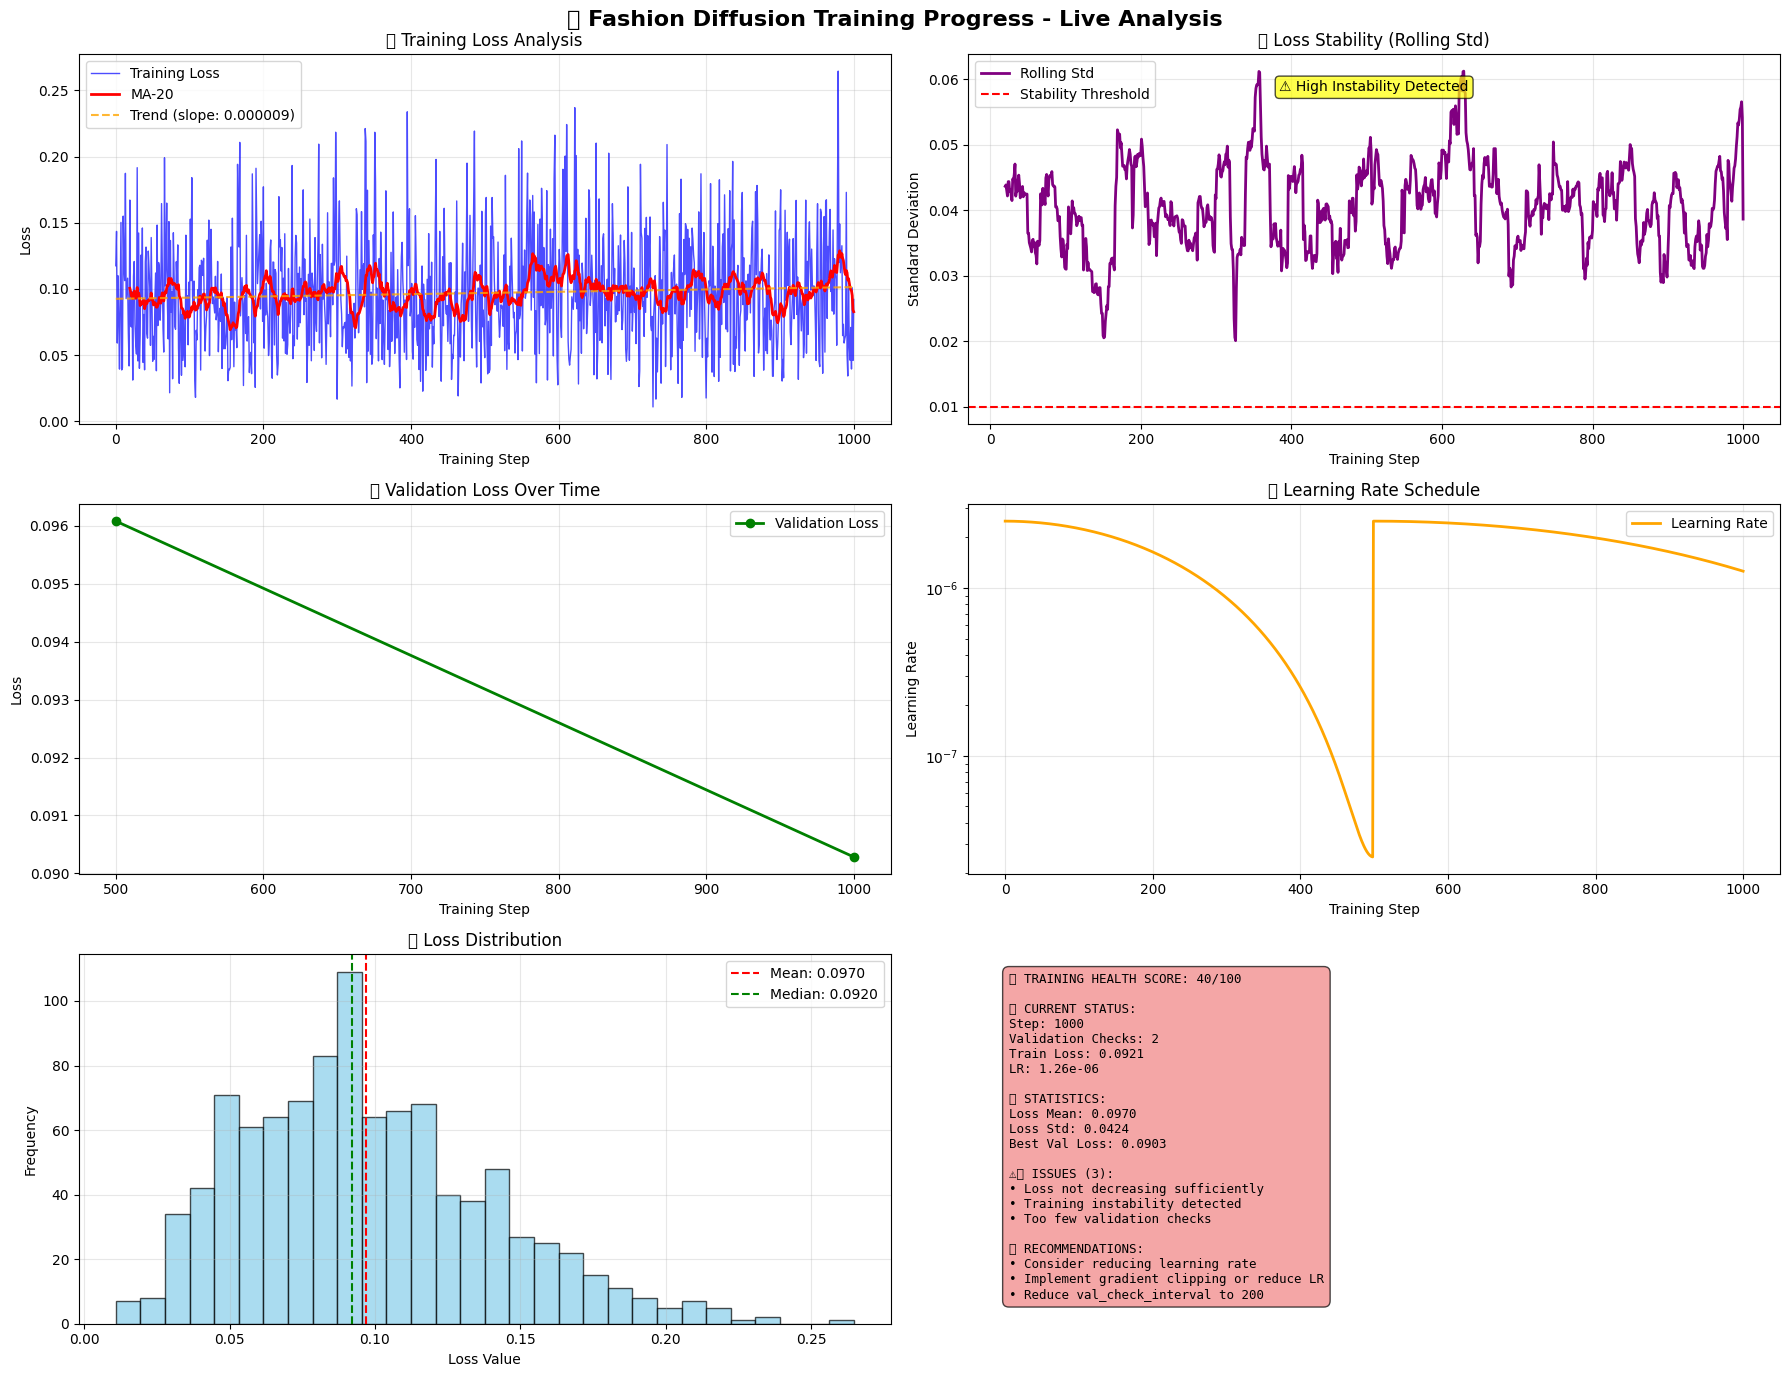


🎯 Training Health Score: 40/100
❌ Training has serious issues that need attention
🚨 Issues detected:
   • Loss not decreasing sufficiently
   • Training instability detected
   • Too few validation checks
💡 Recommendations:
   • Consider reducing learning rate
   • Implement gradient clipping or reduce LR
   • Reduce val_check_interval to 200


Training Progress:  75%|███████▌  | 1501/2000 [1:30:11<29:41,  3.57s/step, loss=0.1382, grad_norm=0.012, lr=2.50e-06]


Validation at step 1500...



Computing validation metrics:  20%|██        | 20/100 [00:20<01:23,  1.05s/it]


📊 Step 1500/2000 (75.0%)
   Train Loss: 0.0952
   Val Loss: 0.1167
   MSE Loss: 0.1167
   MAE Loss: 0.2062
   Loss Std: 0.0512
   Grad Norm: 0.0115
   Learning Rate: 2.50e-06
   Elapsed Time: 90.5 min
   ETA: 29.7 min
   GPU Memory: 2.56 GB
Patience: 1/10


Training Progress: 100%|██████████| 2000/2000 [2:00:16<00:00,  3.61s/step, loss=0.0959, grad_norm=0.010, lr=2.14e-06]


📊 Generating Training Report...
📋 Training Report:
  model_config:
    base_model: runwayml/stable-diffusion-v1-5
    lora_rank: 12
    lora_alpha: 24
    lora_dropout: 0.1
    training_steps: 1999
    best_val_loss: 0.090283203125
    final_learning_rate: 2.137544641718353e-06
  dataset_stats:
    total_valid_images: 9998
    training_samples: 9198
    validation_samples: 800
  training_time:
    total_minutes: 120.28317897319793
    avg_step_time_seconds: 3.569117370605469

🎉 Training completed successfully!
💾 Best model saved at: /kaggle/working/fashion_diffusion_best/best_model
📊 Training logs saved at: /kaggle/working/logs
🖼️ Generated images saved in: /kaggle/working/


In [11]:
# Training loop with advanced monitoring
print("Starting enhanced training...")

pipe.unet.train()
best_val_loss = float('inf')
patience_counter = 0
train_losses = []
learning_rates = []  # FIXED: Initialize learning rates list
step_times = []
start_time = time.time()

# Check available GPU memory
if torch.cuda.is_available():
    gpu_memory = torch.cuda.get_device_properties(device).total_memory / 1e9
    print(f"Available GPU Memory: {gpu_memory:.2f} GB")
    torch.cuda.empty_cache()

# Training progress tracking
train_iterator = iter(train_dataloader)

with tqdm(total=Config.num_steps, desc="Training Progress", unit="step") as pbar:
    for step in range(Config.num_steps):
        step_start_time = time.time()
        
        # Get batch
        try:
            batch = next(train_iterator)
        except StopIteration:
            train_iterator = iter(train_dataloader)
            batch = next(train_iterator)
        
        # Move to device
        latents = batch["latents"].to(device, dtype=torch.float16)
        input_ids = batch["input_ids"].to(device)
        
        # Forward pass with mixed precision
        with autocast('cuda'):
            # Generate noise and timesteps
            noise = torch.randn_like(latents)
            timesteps = torch.randint(
                0, pipe.scheduler.config.num_train_timesteps,
                (latents.shape[0],), device=device
            ).long()
            
            # Add noise to latents
            noisy_latents = pipe.scheduler.add_noise(latents, noise, timesteps)
            
            # Get text embeddings
            text_embeddings = pipe.text_encoder(input_ids)[0]
            
            # Predict noise
            noise_pred = pipe.unet(
                noisy_latents, timesteps, encoder_hidden_states=text_embeddings
            ).sample
            
            # Calculate loss
            loss = F.mse_loss(noise_pred, noise)
        
        # Backward pass
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        
        # Gradient clipping
        grad_norm = torch.nn.utils.clip_grad_norm_(
            pipe.unet.parameters(), Config.gradient_clip_norm
        )
        
        # Optimizer step
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        optimizer.zero_grad()
        
        # Track metrics - FIXED: Proper learning rate tracking
        train_losses.append(loss.item())
        current_lr = scheduler.get_last_lr()[0] if hasattr(scheduler, 'get_last_lr') else optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)
        step_time = time.time() - step_start_time
        step_times.append(step_time)
        
        # Update progress bar
        pbar.update(1)
        pbar.set_postfix({
            "loss": f"{loss.item():.4f}",
            "grad_norm": f"{grad_norm:.3f}",
            "lr": f"{current_lr:.2e}"
        })
        
        # Memory management every 100 steps
        if step % 100 == 0 and step > 0:
            torch.cuda.empty_cache()
        
        # Validation and checkpointing
        if step % Config.val_check_interval == 0 and step > 0:
            print(f"\nValidation at step {step}...")
            
            # Compute validation metrics
            val_metrics = evaluator.compute_validation_metrics(val_dataloader, max_batches=20, step=step)
            val_loss = val_metrics['val_loss']
            
            # Progress statistics
            elapsed_time = time.time() - start_time
            avg_step_time = np.mean(step_times[-100:]) if len(step_times) >= 100 else np.mean(step_times)
            eta_minutes = (Config.num_steps - step) * avg_step_time / 60
            gpu_memory = torch.cuda.memory_allocated(device) / 1e9 if torch.cuda.is_available() else 0
            
            print(f"📊 Step {step}/{Config.num_steps} ({step/Config.num_steps*100:.1f}%)")
            print(f"   Train Loss: {np.mean(train_losses[-Config.val_check_interval:]):.4f}")
            print(f"   Val Loss: {val_loss:.4f}")
            print(f"   MSE Loss: {val_metrics['mse_loss']:.4f}")
            print(f"   MAE Loss: {val_metrics['mae_loss']:.4f}")
            print(f"   Loss Std: {val_metrics['loss_std']:.4f}")
            print(f"   Grad Norm: {grad_norm:.4f}")
            print(f"   Learning Rate: {current_lr:.2e}")
            print(f"   Elapsed Time: {elapsed_time/60:.1f} min")
            print(f"   ETA: {eta_minutes:.1f} min")
            print(f"   GPU Memory: {gpu_memory:.2f} GB")
            
            # Save best model
            if val_loss < best_val_loss - Config.min_delta:
                best_val_loss = val_loss
                patience_counter = 0
                
                # Save model
                model_save_path = os.path.join(Config.model_save_dir, "best_model")
                os.makedirs(model_save_path, exist_ok=True)
                
                # Save LoRA weights
                pipe.unet.save_pretrained(model_save_path)
                
                # Save additional components
                pipe.scheduler.save_pretrained(os.path.join(model_save_path, "scheduler"))
                
                # Save training state
                torch.save({
                    'step': step,
                    'best_val_loss': best_val_loss,
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'train_losses': train_losses,
                    'learning_rates': learning_rates,  # FIXED: Save proper learning rates
                    'val_metrics': val_metrics,
                }, os.path.join(model_save_path, "training_state.pt"))
                
                print(f"New best model saved! Val Loss: {val_loss:.4f}")
                
            else:
                patience_counter += 1
                print(f"Patience: {patience_counter}/{Config.patience}")
                
                if patience_counter >= Config.patience:
                    print(f"Early stopping triggered at step {step}")
                    print(f"   Best validation loss: {best_val_loss:.4f}")
                    break
            
            # Plot progress - FIXED: Use proper learning rates list
            if step % (Config.val_check_interval * 2) == 0:
                print("📊 Generating training progress plots...")
                evaluator.plot_training_progress(
                    train_losses=train_losses,
                    learning_rates=learning_rates,  # Use the tracked learning rates
                    current_step=step
                )
            
            # Memory cleanup
            torch.cuda.empty_cache()
            gc.collect()


# Generate training progress report
print("\n📊 Generating Training Report...")

training_report = {
    "model_config": {
        "base_model": "runwayml/stable-diffusion-v1-5",
        "lora_rank": Config.lora_rank,
        "lora_alpha": Config.lora_alpha,
        "lora_dropout": Config.lora_dropout,
        "training_steps": step,
        "best_val_loss": best_val_loss,
        "final_learning_rate": scheduler.get_last_lr()[0]
    },
    "dataset_stats": {
        "total_valid_images": len(valid_images),
        "training_samples": len(train_dataset),
        "validation_samples": len(val_dataset)
    },
    "training_time": {
        "total_minutes": (time.time() - start_time) / 60,
        "avg_step_time_seconds": np.mean(step_times)
    }
}

# Save training report
with open(os.path.join(Config.logs_dir, "training_report.json"), "w") as f:
    json.dump(training_report, f, indent=2)

print("📋 Training Report:")
for section, data in training_report.items():
    print(f"  {section}:")
    for key, value in data.items():
        print(f"    {key}: {value}")

print("\n🎉 Training completed successfully!")
print(f"💾 Best model saved at: {os.path.join(Config.model_save_dir, 'best_model')}")
print(f"📊 Training logs saved at: {Config.logs_dir}")
print(f"🖼️ Generated images saved in: /kaggle/working/")

# Validation

In [12]:
def load_trained_model(model_path="/kaggle/working/fashion_diffusion_best/best_model"):
    """Function to load the trained model for inference"""
    print("🔄 Loading trained fashion diffusion model...")
    
    try:
        # Load base pipeline
        pipe = StableDiffusionPipeline.from_pretrained(
            "runwayml/stable-diffusion-v1-5", 
            torch_dtype=torch.float16,
            safety_checker=None,
            requires_safety_checker=False
        )
        pipe = pipe.to(device)
        
        # Setup scheduler
        pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
        
        # Load LoRA weights
        if os.path.exists(model_path):
            # Create LoRA config - FIXED: Use same target_modules as training
            lora_config = LoraConfig(
                r=Config.lora_rank,
                lora_alpha=Config.lora_alpha,
                target_modules=[
                    "to_k", "to_q", "to_v", "to_out.0",
                    "proj_in", "proj_out",  # Added back
                    "conv1", "conv2"        # Added back
                ],
                lora_dropout=Config.lora_dropout,
            )
            
            # Apply LoRA and load weights
            pipe.unet = get_peft_model(pipe.unet, lora_config)
            pipe.unet.load_adapter(model_path)
            print(f"✅ Model loaded successfully from {model_path}")
        else:
            print(f"⚠️ Model path {model_path} not found. Using base model.")
        
        return pipe
        
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return None


def generate_fashion_images(pipe, prompts, output_dir="/kaggle/working/generated"):
    """Generate fashion images using the trained model"""
    os.makedirs(output_dir, exist_ok=True)
    
    enhanced_negative_prompt = (
        "multiple people, crowd, group, blurry, distorted, low quality, bad anatomy, "
        "disfigured hands, malformed hands, extra limbs, missing limbs, ugly face, "
        "asymmetric features, duplicate, clone, bad proportions"
    )
    
    generated_images = []
    
    for i, prompt in enumerate(prompts):
        print(f"🎨 Generating image {i+1}: {prompt[:50]}...")
        
        try:
            with torch.no_grad():
                image = pipe(
                    prompt,
                    num_inference_steps=50,
                    guidance_scale=12.0,
                    negative_prompt=enhanced_negative_prompt,
                    height=512,
                    width=512
                ).images[0]
                
                filename = os.path.join(output_dir, f"fashion_generated_{i+1}.png")
                image.save(filename, quality=95, optimize=True)
                generated_images.append(filename)
                print(f"   ✅ Saved: {filename}")
                
        except Exception as e:
            print(f"   ❌ Error generating image {i+1}: {e}")
            continue
    
    return generated_images


Final Model Evaluation
📥 Attempting to load best model...


/usr/local/lib/python3.11/dist-packages/peft/peft_model.py:599: UserWarning: Found missing adapter keys while loading the checkpoint: ['base_model.model.base_model.model.down_blocks.0.attentions.0.proj_in.lora_A.default.weight', 'base_model.model.base_model.model.down_blocks.0.attentions.0.proj_in.lora_B.default.weight', 'base_model.model.base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q.lora_A.default.weight', 'base_model.model.base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q.lora_B.default.weight', 'base_model.model.base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_k.lora_A.default.weight', 'base_model.model.base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_k.lora_B.default.weight', 'base_model.model.base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_v.lora_A.default.weight', 'base_model.model.base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn

✅ Successfully loaded best model with PeftModel
📊 Loading training history...


/tmp/ipykernel_19/644005117.py:343: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_19/644005117.py:343: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_19/644005117.py:343: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_19/644005117.py:343: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_19/644005117.py:343: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_19/644005117.py:343: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_19/644005117.py:343: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from current font.
  plt.tight_layout()


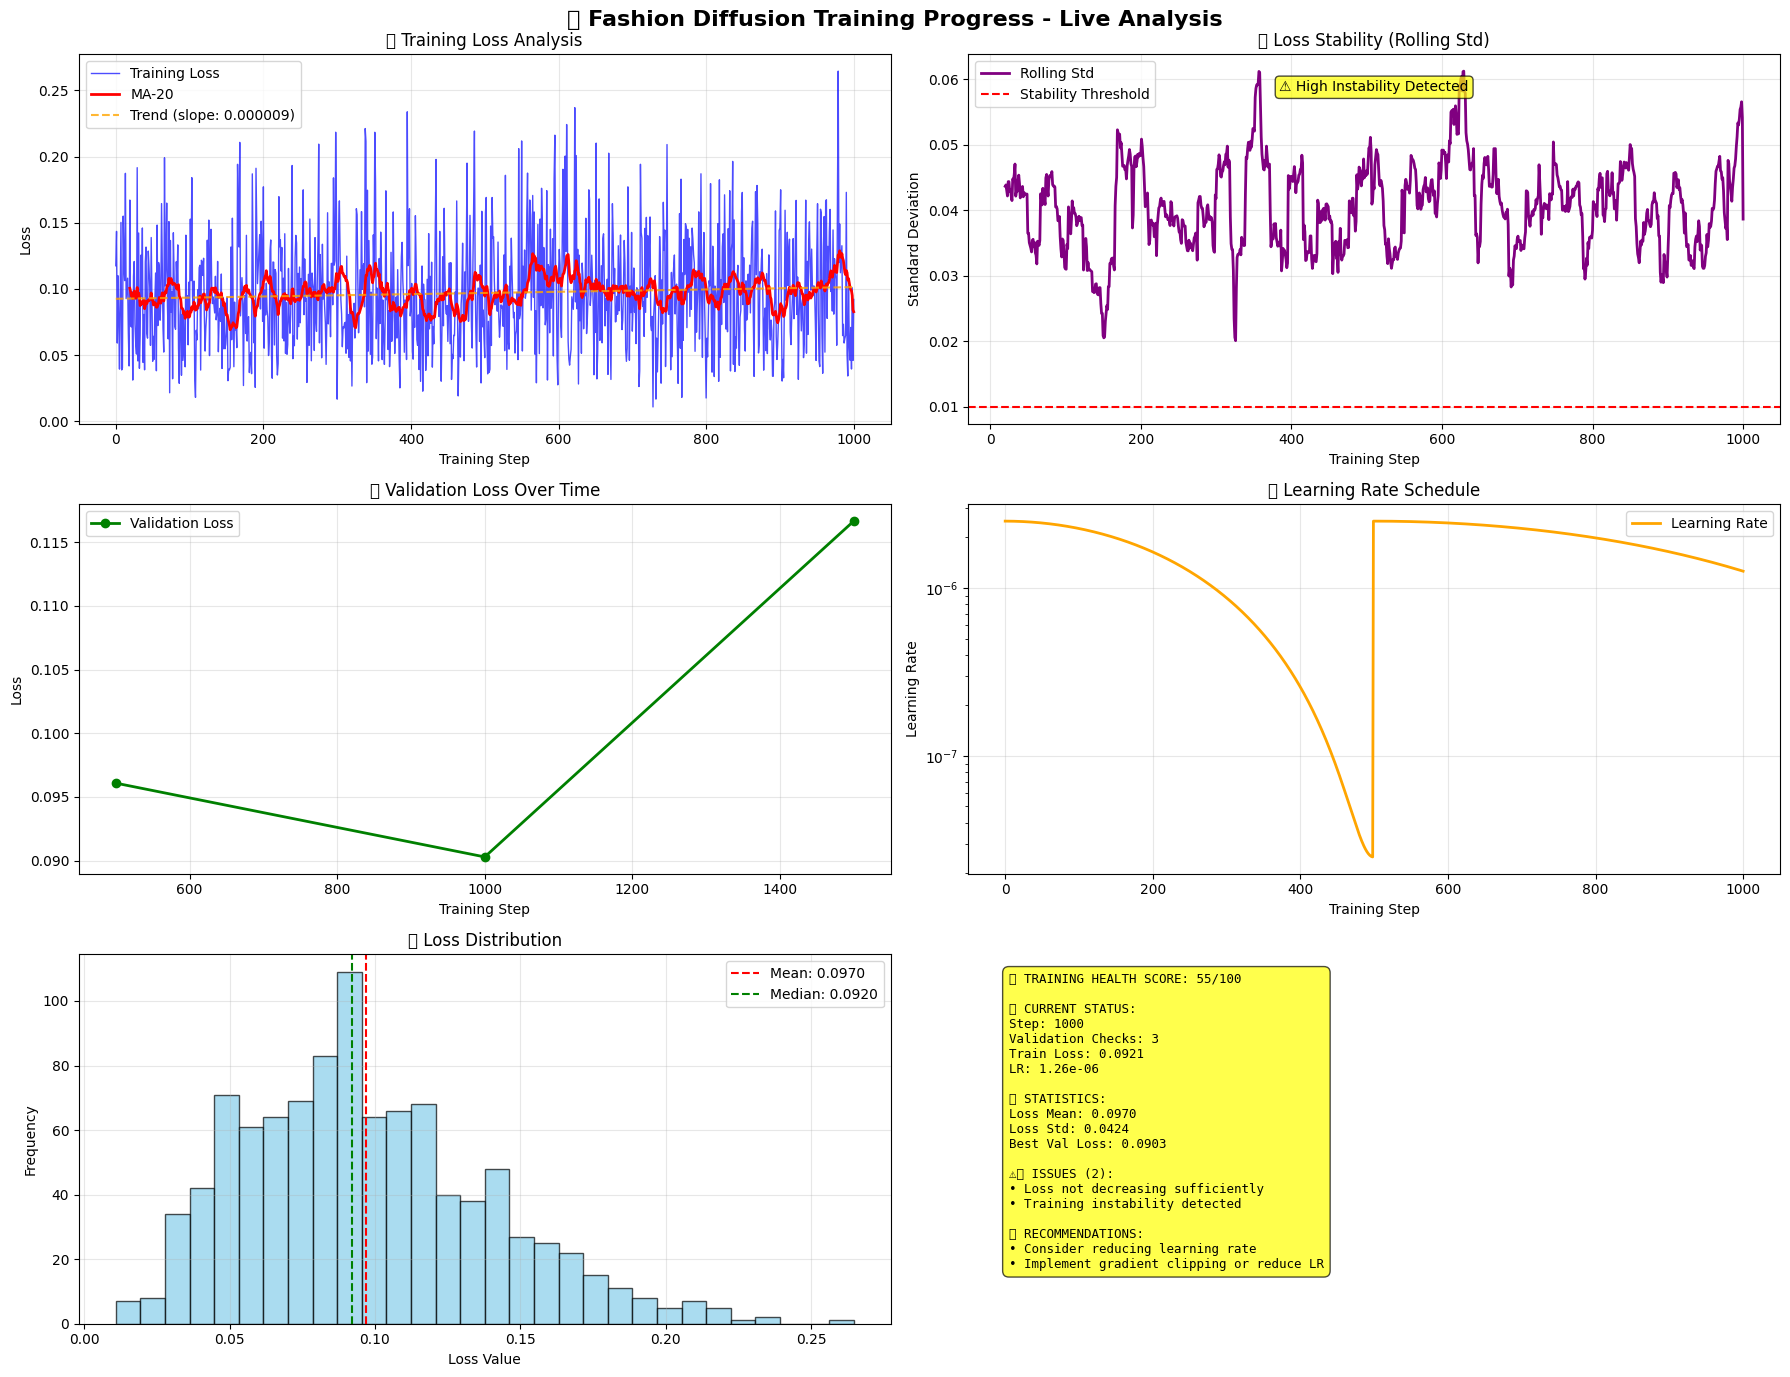


🎯 Training Health Score: 55/100
⚠️ Training has some issues but is manageable
🚨 Issues detected:
   • Loss not decreasing sufficiently
   • Training instability detected
💡 Recommendations:
   • Consider reducing learning rate
   • Implement gradient clipping or reduce LR
✅ Plotted training history up to step 1000


In [13]:
# Step 10: Final model evaluation and testing
print("\nFinal Model Evaluation")
print("="*50)

# Load best model for final evaluation safely
model_loaded = safe_load_best_model()

if not model_loaded:
    print("Proceeding with base model for evaluation")

# Load and display training history
load_and_plot_training_history()

# Kết quả

Generating final test images...

📝 Prompt 1: chic woman in a modern minimalist jumpsuit with cl...


  0%|          | 0/20 [00:00<?, ?it/s]

   ✅ Saved: steps=20, guidance=12.0
  Step 20 version:


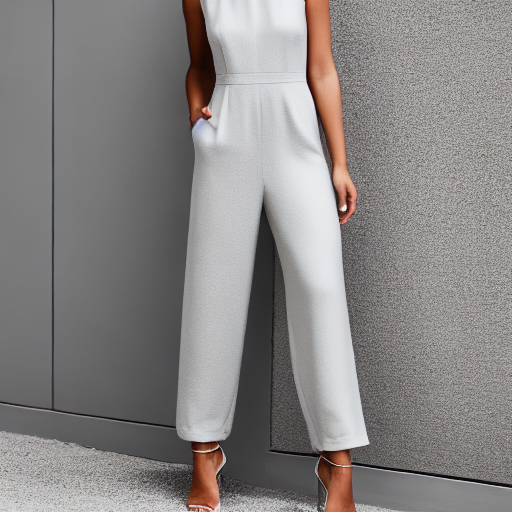

  0%|          | 0/30 [00:00<?, ?it/s]

   ✅ Saved: steps=30, guidance=12.0
  Step 30 version:


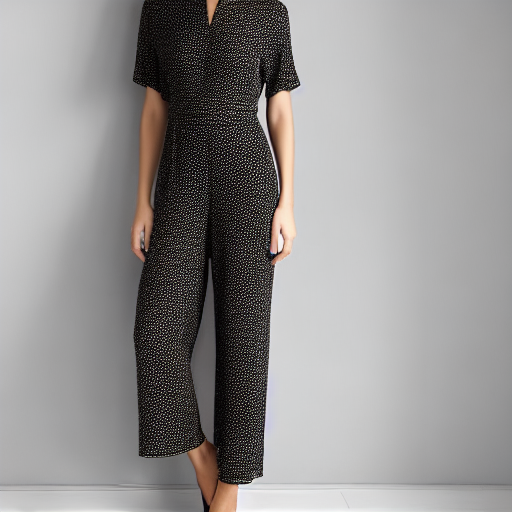

  0%|          | 0/50 [00:00<?, ?it/s]

   ✅ Saved: steps=50, guidance=12.0
  Step 50 version:


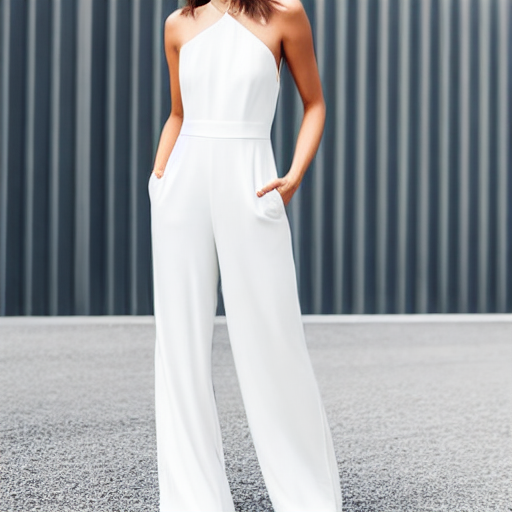


📝 Prompt 2: confident man in a vibrant streetwear outfit with ...


  0%|          | 0/20 [00:00<?, ?it/s]

   ✅ Saved: steps=20, guidance=12.0
  Step 20 version:


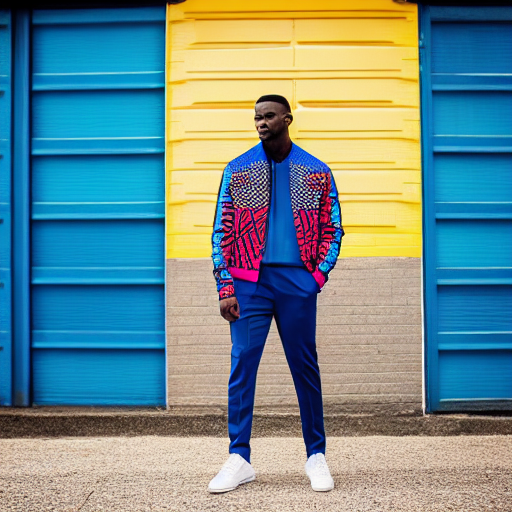

  0%|          | 0/30 [00:00<?, ?it/s]

   ✅ Saved: steps=30, guidance=12.0
  Step 30 version:


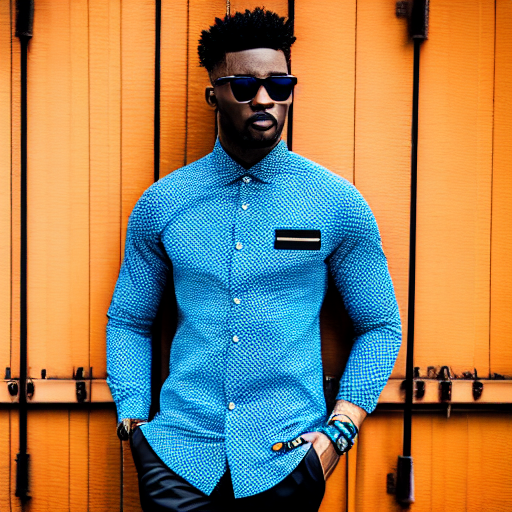

  0%|          | 0/50 [00:00<?, ?it/s]

   ✅ Saved: steps=50, guidance=12.0
  Step 50 version:


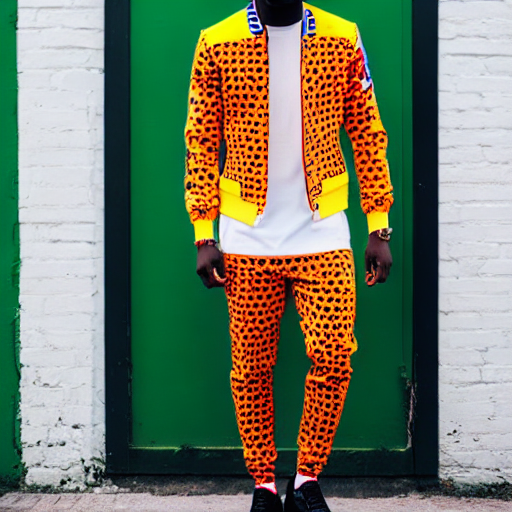


📝 Prompt 3: elegant model in a vintage-inspired velvet blazer ...


  0%|          | 0/20 [00:00<?, ?it/s]

   ✅ Saved: steps=20, guidance=12.0
  Step 20 version:


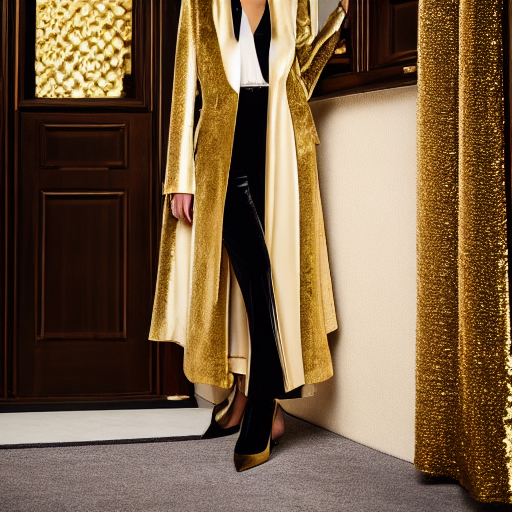

  0%|          | 0/30 [00:00<?, ?it/s]

   ✅ Saved: steps=30, guidance=12.0
  Step 30 version:


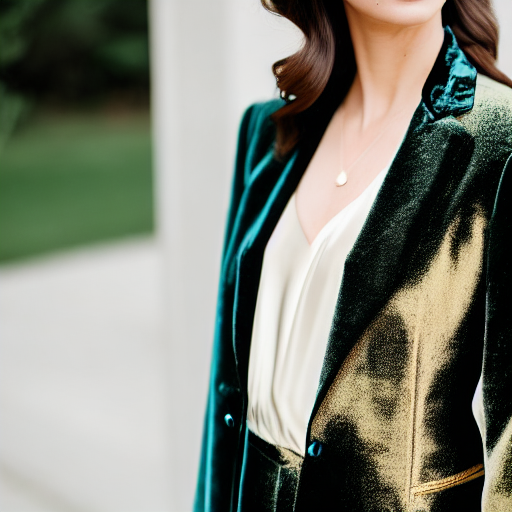

  0%|          | 0/50 [00:00<?, ?it/s]

   ✅ Saved: steps=50, guidance=12.0
  Step 50 version:


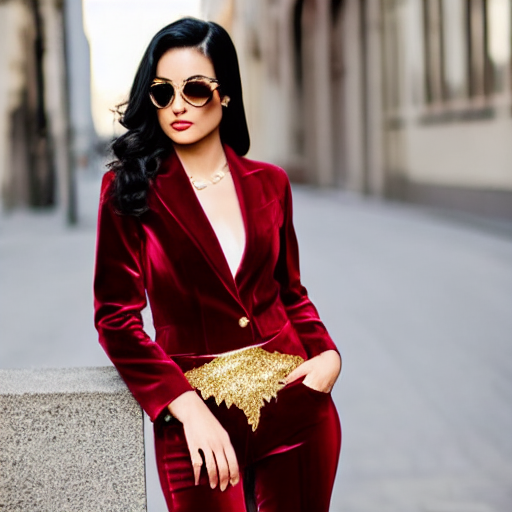


📝 Prompt 4: stylish man in a tailored black suit, studio light...


  0%|          | 0/20 [00:00<?, ?it/s]

   ✅ Saved: steps=20, guidance=12.0
  Step 20 version:


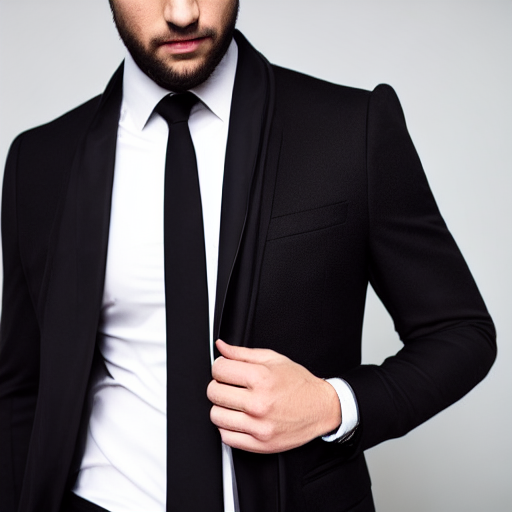

  0%|          | 0/30 [00:00<?, ?it/s]

   ✅ Saved: steps=30, guidance=12.0
  Step 30 version:


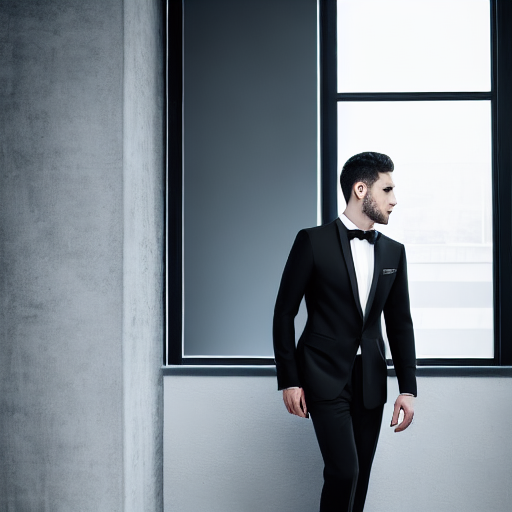

  0%|          | 0/50 [00:00<?, ?it/s]

   ✅ Saved: steps=50, guidance=12.0
  Step 50 version:


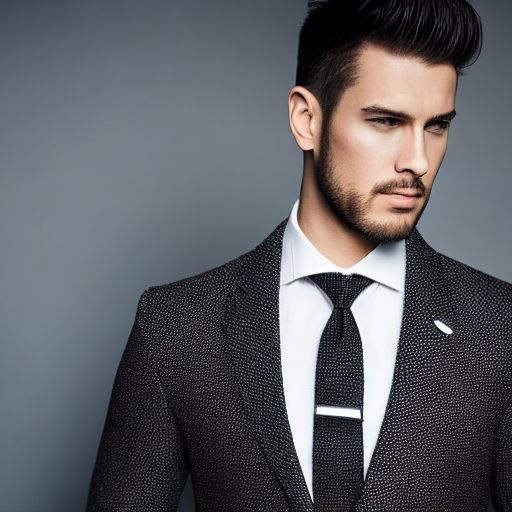


📝 Prompt 5: graceful woman in a romantic lace midi dress with ...


  0%|          | 0/20 [00:00<?, ?it/s]

   ✅ Saved: steps=20, guidance=12.0
  Step 20 version:


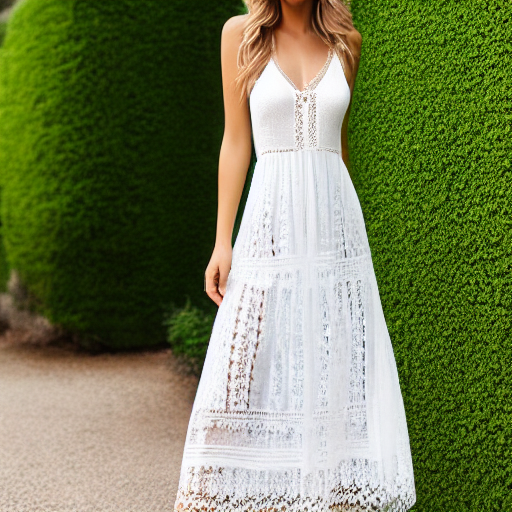

  0%|          | 0/30 [00:00<?, ?it/s]

   ✅ Saved: steps=30, guidance=12.0
  Step 30 version:


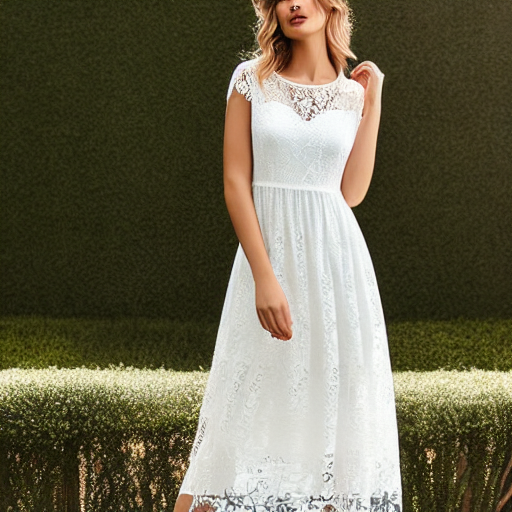

  0%|          | 0/50 [00:00<?, ?it/s]

   ✅ Saved: steps=50, guidance=12.0
  Step 50 version:


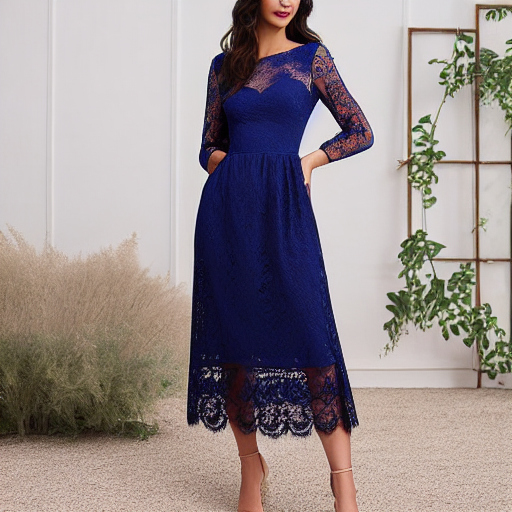

In [14]:
test_prompts = [
    "chic woman in a modern minimalist jumpsuit with clean lines, professional fashion photography, single model, high resolution",

    "confident man in a vibrant streetwear outfit with bold graphic prints, urban fashion shoot, one person, detailed textures",

    "elegant model in a vintage-inspired velvet blazer with gold accents, luxury fashion photography, single person, high quality",

    "stylish man in a tailored black suit, studio lighting, professional photography, single person, high resolution",

    "graceful woman in a romantic lace midi dress with delicate embroidery, soft outdoor lighting, single model, high resolution"
]

# Enhanced negative prompt for better quality
enhanced_negative_prompt = (
    "multiple people, crowd, group, blurry, distorted, low quality, bad anatomy, "
    "disfigured hands, malformed hands, extra limbs, missing limbs, ugly face, "
    "asymmetric features, duplicate, clone, bad proportions, extra fingers, "
    "fewer fingers, long neck, cropped, worst quality, jpeg artifacts, signature, "
    "watermark, username, text, error, extra digit, cropped, lowres, normal quality"
)

print("Generating final test images...")

# Generate images with different inference steps for comparison
inference_steps_options = [20, 30, 50]
# guidance_scales = [7.5, 12.0, 15.0]
guidance_scales = [12.0]

for i, prompt in enumerate(test_prompts):
    print(f"\n📝 Prompt {i+1}: {prompt[:50]}...")
    
    for steps in inference_steps_options:
        for guidance in guidance_scales:
            try:
                with torch.no_grad():
                    image = pipe(
                        prompt,
                        num_inference_steps=steps,
                        guidance_scale=guidance,
                        negative_prompt=enhanced_negative_prompt,
                        height=512,
                        width=512
                    ).images[0]
                    
                    # Save with descriptive filename
                    filename = f"/kaggle/working/final_generated_p{i+1}_s{steps}_g{guidance:.1f}.png"
                    image.save(filename, quality=95, optimize=True)
                    print(f"   ✅ Saved: steps={steps}, guidance={guidance}")
                    
                    # Display best quality version (50 steps, guidance 12.0)
                    if steps == 20 and guidance == 12.0:
                        print(f"  Step 20 version:")
                        display(IPImage(filename=filename))
                    elif steps == 30 and guidance == 12.0:
                        print(f"  Step 30 version:")
                        display(IPImage(filename=filename))
                    elif steps == 50 and guidance == 12.0:
                        print(f"  Step 50 version:")
                        display(IPImage(filename=filename))
                        
            except Exception as e:
                print(f"   ❌ Error: {e}")
                continue
